In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [2]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    #os.makedirs(housing_path, exist_ok = True)
    if not os.path.isdir(housing_path): #method to check whether the specified path is an existing directory or not
        os.makedirs(housing_path) #Recursive directory creation function. 
        #Like mkdir(), but makes all intermediate-level directories needed to contain the leaf directory.
    tgz_path = os.path.join(housing_path, "housing.tgz")
    #Join one or more path components intelligently. The return value is the concatenation of path and any 
    #members of *paths with exactly one directory separator following each non-empty part
    urllib.request.urlretrieve(housing_url, tgz_path)
    #The urllib.request module defines functions and classes which help in opening URLs
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
fetch_housing_data()

In [3]:
import pandas as pd
import numpy as np
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()
#median_house_value - target attribute

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.shape #fairly small dataset

(20640, 10)

In [6]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [7]:
housing.info() #total_bedrooms

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.isnull().mean()# bedrooms data missing # All numerical except 'ocean_proximity'

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

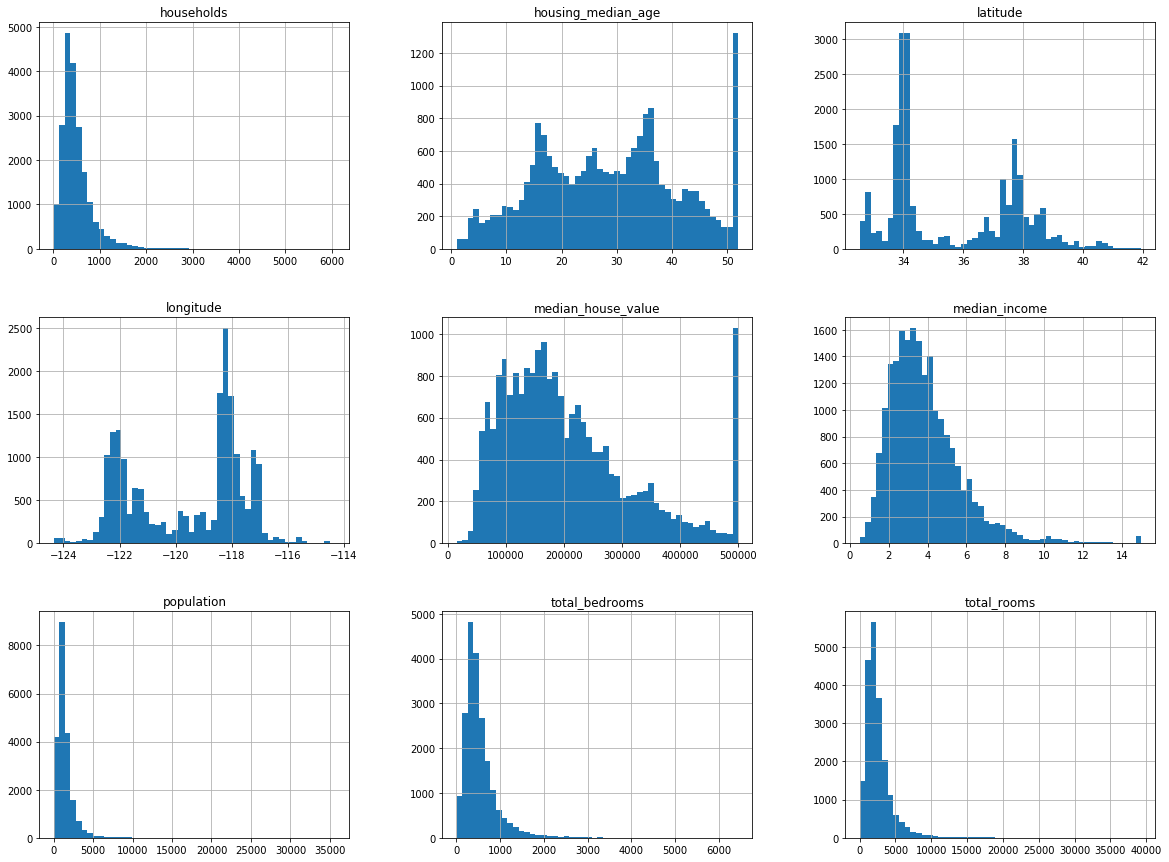

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
housing.hist(bins = 50, figsize = (20,15));
#plt.show()
#median_income, house_median_age and median_housing_value are all scaled(capped) & not in their real numbers
# Some have tail heavy distributions (not ideal gaussian)

In [11]:
#Create a test set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
# to have a stable train & test set even after the data sets is updated, use each instances unique identifier to decide whether 
#it should got to train or test set. Compute a hash for each instance
from zlib import crc32
def test_set_check(identifiers, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio *2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
#Compute a hash for each instance by hash functions
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [15]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
train_set.head(3)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
train_set.head(3)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15


In [17]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

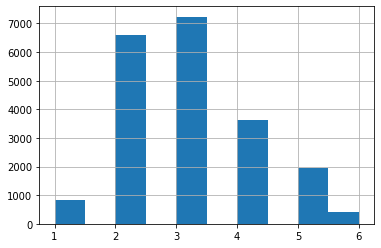

In [18]:
#median_income is important for median_housing_value; categorize the column - 'pd.cut'
housing['income_cat'] = pd.cut(housing['median_income'], bins = [0.0, 1.5, 3.0, 4.5, 6.0,9.0, np.inf], labels = [1,2,3,4,5,6])
housing['income_cat'].hist()

In [19]:
# stratified sampling based on income category - 'scikit learn StratifiedShuffledSplit'
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.094719
1    0.039729
6    0.019864
Name: income_cat, dtype: float64

In [20]:
# To generate income category proportions in data set, test set
def income_cat_props(data):
    return data['income_cat'].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

compare_props = pd.DataFrame({'Overall': income_cat_props(housing), 'Stratified': income_cat_props(strat_test_set),
                              'Random': income_cat_props(test_set)}).sort_index()
                                                                                
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-2.433090e-01
2,0.318847,0.318798,0.324370,1.732260,-1.519526e-02
3,0.350581,0.350533,0.358527,2.266446,-1.381979e-02
4,0.176308,0.176357,0.167393,-5.056334,2.748008e-02
5,0.094719,0.094719,0.089632,-5.370844,-1.421085e-14
6,0.019719,0.019864,0.019864,0.737101,7.371007e-01


In [21]:
# remove income_cat attribute so that data is back tot he original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace = True)


In [22]:
# creating a copy of the train_set for exploration
housing = strat_train_set.copy()

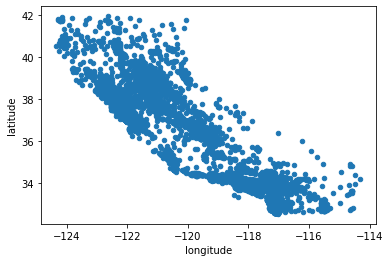

In [23]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude')

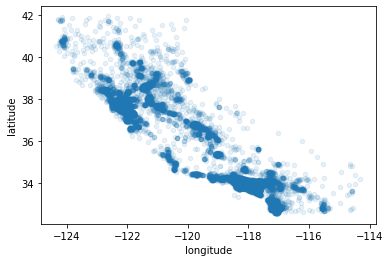

In [24]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

Text(0.5, 0, 'Longitude')

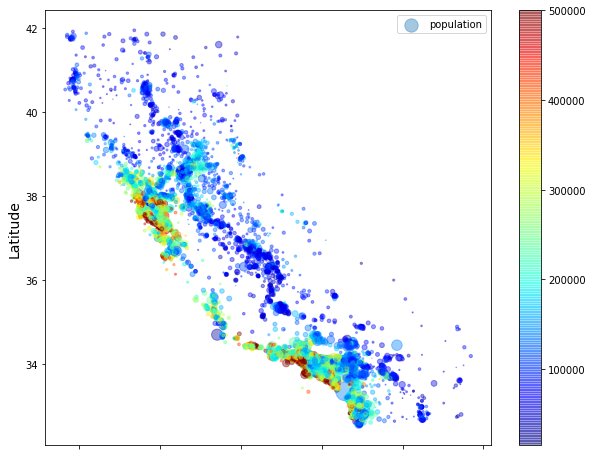

In [25]:
housing.plot(kind = 'scatter', x = 'longitude', y= 'latitude', alpha = 0.4, s = housing['population']/100, label = 'population',
            figsize = (10,8),  c= housing['median_house_value'], cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
#c attribute of plot - color --> median_house_value
#s attribute of plot - marker size --> population

In [26]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [27]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))
#The urllib.request module defines functions and classes which help in opening URLs

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x18fa5a05488>)

Saving figure california_housing_prices_plot


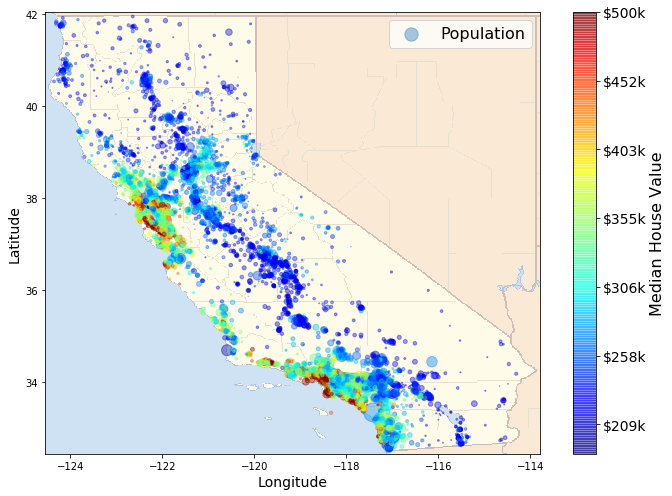

In [28]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
#images read from the png files
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
#same plot as above
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
#images are rendered
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [29]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)
#9 attributes

median_house_value    1.000000
median_income         0.688700
total_rooms           0.137086
housing_median_age    0.111252
households            0.066194
total_bedrooms        0.049339
population           -0.023645
longitude            -0.050532
latitude             -0.140327
Name: median_house_value, dtype: float64

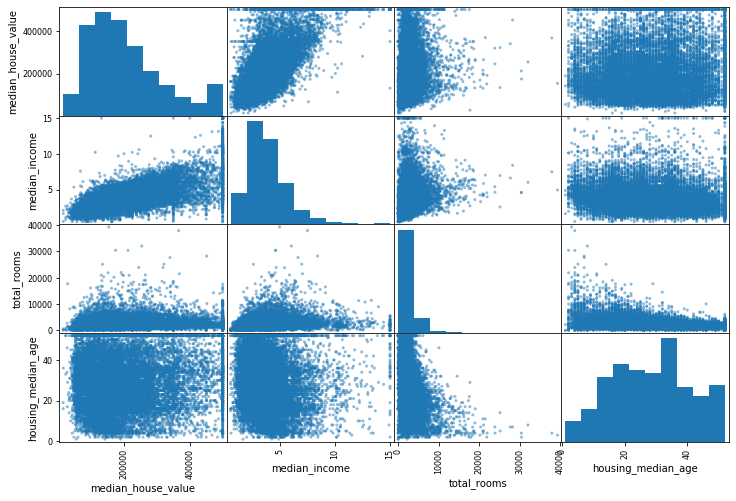

In [30]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12,8));
#first 4 attributes

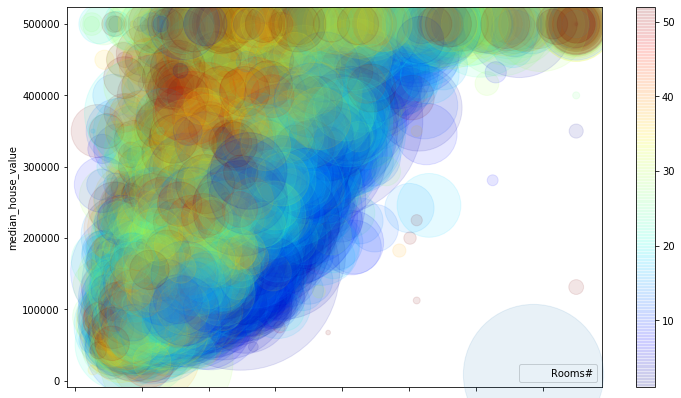

In [31]:
housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1, figsize = (12,7),
             s = housing['total_rooms'], label = 'Rooms#', c= housing['housing_median_age'], 
             cmap = plt.get_cmap('jet'), colorbar = True)
#trail - pointless

In [32]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
#rooma_per-household has higher correlation to median_house_value than total_rooms
#12 attributes/features

median_house_value          1.000000
median_income               0.688700
rooms_per_household         0.146045
total_rooms                 0.137086
housing_median_age          0.111252
households                  0.066194
total_bedrooms              0.049339
population                 -0.023645
population_per_household   -0.032140
longitude                  -0.050532
latitude                   -0.140327
bedrooms_per_room          -0.261121
Name: median_house_value, dtype: float64

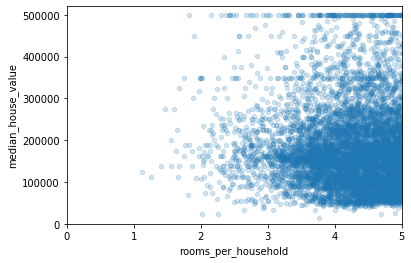

In [34]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.579181,35.641102,28.640383,2627.578488,535.682035,1421.430899,497.633358,3.873380,207063.013445,5.441013,0.212899,3.022903
std,2.002694,2.137491,12.578867,2151.905032,413.537093,1118.273435,376.519336,1.900485,115692.256048,2.612661,0.057342,6.406708
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.810000,33.940000,18.000000,1444.000000,295.000000,785.000000,279.000000,2.566775,119800.000000,4.441091,0.175255,2.432493
50%,-118.520000,34.265000,29.000000,2120.500000,433.000000,1164.500000,408.000000,3.540900,179500.000000,5.233333,0.203040,2.820312
75%,-118.010000,37.720000,37.000000,3149.000000,645.000000,1721.250000,602.000000,4.744475,264325.000000,6.057729,0.239843,3.281506
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,599.714286


In [36]:
#function for data cleaning - used for transformations of attributes - 
#helpful to build a library of those functions for future use + try combinations of transformations
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [37]:
# missing enteries
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5665,-118.29,33.73,30.0,3161.0,NaN,1865.0,771.0,2.7139,NEAR OCEAN
2420,-119.44,36.58,37.0,1054.0,NaN,879.0,257.0,2.5234,INLAND
7330,-118.17,33.98,41.0,756.0,NaN,873.0,212.0,2.7321,<1H OCEAN
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,<1H OCEAN
6220,-117.91,34.05,35.0,3189.0,NaN,1727.0,500.0,5.0758,<1H OCEAN


In [38]:
len(sample_incomplete_rows)

5

In [39]:
#fill the missing values with median
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5665,-118.29,33.73,30.0,3161.0,433.0,1865.0,771.0,2.7139,NEAR OCEAN
2420,-119.44,36.58,37.0,1054.0,433.0,879.0,257.0,2.5234,INLAND
7330,-118.17,33.98,41.0,756.0,433.0,873.0,212.0,2.7321,<1H OCEAN
20484,-118.72,34.28,17.0,3051.0,433.0,1705.0,495.0,5.7376,<1H OCEAN
6220,-117.91,34.05,35.0,3189.0,433.0,1727.0,500.0,5.0758,<1H OCEAN


In [40]:
#Scikit-Learn has a handy class for missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [41]:
housing_num = housing.drop('ocean_proximity', axis =1)

In [42]:
#Remove the text(object dtype) attribute because median can only be calculated on numerical attributes:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [43]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [44]:
imputer.statistics_

array([-118.52  ,   34.265 ,   29.    , 2120.5   ,  433.    , 1164.5   ,
        408.    ,    3.5409])

In [45]:
housing_num.median().values
##use the 'trained' imputer to transform the training set by  replacing missing values witht he learned medians

array([-118.52  ,   34.265 ,   29.    , 2120.5   ,  433.    , 1164.5   ,
        408.    ,    3.5409])

In [46]:
X = imputer.transform(housing_num)

In [47]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20079,-120.41,38.03,14.0,2061.0,465.0,859.0,462.0,2.1289
19094,-122.60,38.24,16.0,1410.0,209.0,741.0,229.0,4.7250
7902,-118.04,33.86,21.0,2870.0,437.0,1671.0,470.0,7.2628
13744,-117.17,34.07,24.0,6573.0,1235.0,2904.0,1202.0,3.0651
1329,-121.88,38.00,16.0,2605.0,440.0,1352.0,408.0,4.1947


In [48]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)
#categorical attributes as seen before - 5 types
#most ML algos work with numbers. So will need to convert the text of attributes to numbers

,ocean_proximity
20079,INLAND
19094,<1H OCEAN
7902,<1H OCEAN
13744,INLAND
1329,INLAND
13753,INLAND
7677,<1H OCEAN
6374,INLAND
3029,INLAND
467,NEAR BAY


In [49]:
#About OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [3.]])

In [50]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [51]:
# Previously used OneHotEncoder- help create binary attribute per category
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
# output is sparse matrix and not a numpy array- to reduce memory to store 0s after using the transformation

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [52]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [53]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [54]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [55]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
# A CLASS is built for adding different transformers
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [57]:
#hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, 
#but it would be much cleaner to get them dynamically, like this:
col_names = 'total_rooms', 'total_bedrooms', 'population', 'households'
rooms_ix, bedrooms_ix, population_ix, househols_ix =[housing.columns.get_loc(c) for c in col_names]
# get the column indices


In [58]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,
                                     columns= list(housing.columns)+['rooms_per_household', 'population_per_household'],
                                     index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
20079,-120.41,38.03,14,2061,465,859,462,2.1289,INLAND,4.46104,1.85931
19094,-122.6,38.24,16,1410,209,741,229,4.725,<1H OCEAN,6.15721,3.23581
7902,-118.04,33.86,21,2870,437,1671,470,7.2628,<1H OCEAN,6.10638,3.55532
13744,-117.17,34.07,24,6573,1235,2904,1202,3.0651,INLAND,5.46839,2.41597
1329,-121.88,38,16,2605,440,1352,408,4.1947,INLAND,6.3848,3.31373


In [59]:
#PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')),
                        ('attrib_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [60]:
housing_num_tr

array([[-0.41486313,  1.11765169, -1.16392252, ..., -0.37509775,
        -0.18162702,  0.18193608],
       [-1.5084232 ,  1.21590068, -1.00492087, ...,  0.27413215,
         0.03323248, -1.00270154],
       [ 0.76857858, -0.83329256, -0.60741674, ...,  0.25467927,
         0.08310536, -0.94089389],
       ...,
       [ 0.77357201, -0.87539927, -0.13041178, ...,  0.52121182,
        -0.00463687, -0.8990262 ],
       [ 0.80353256, -0.74440061,  0.58509565, ..., -0.30972111,
         0.10747487, -0.64097678],
       [ 1.25294081, -1.23096704, -1.87942996, ...,  0.5858128 ,
        -0.11647229, -0.72392095]])

In [61]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [62]:
#For reference, here is the old solution based on a 
#DataFrameSelector transformer (to just select a subset of the Pandas DataFrame columns), and a FeatureUnion:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [63]:
#Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [64]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [65]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-0.41486313,  1.11765169, -1.16392252, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5084232 ,  1.21590068, -1.00492087, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76857858, -0.83329256, -0.60741674, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.77357201, -0.87539927, -0.13041178, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.80353256, -0.74440061,  0.58509565, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.25294081, -1.23096704, -1.87942996, ...,  0.        ,
         0.        ,  0.        ]])

In [66]:
np.allclose(housing_prepared, old_housing_prepared)

True

Select and Train a model - linear regression

In [67]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [ 74164.29942964 236690.56556611 325847.75950903 149633.56166044
 168380.08547736]


In [69]:
print('Labels:', list(some_labels))

Labels: [115300.0, 204500.0, 322700.0, 108000.0, 140300.0]


In [70]:
#To calcluate the RMSE on the whole train set
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  #model underfitting train data

68549.47943844512

In [71]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49391.6801998487

In [72]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [73]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse  # maybe overfitting; Need for cross validation - training set divided to smaller train set & validation set

0.0

In [74]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [75]:
def display_scores(scores):
    print('scores:', scores)
    print('mean:',scores.mean())
    print('standard deviation:', scores.std())

In [76]:
display_scores(tree_rmse_scores) #Overfitting; worse than linear regressor

scores: [69145.01870727 72453.62570311 70363.04620263 75188.59173839
 72187.11187978 75971.30409861 74050.1543023  74381.62488369
 73754.47553674 70384.3432112 ]
mean: 72787.92962637251
standard deviation: 2153.2572216386848


In [77]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [78]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18690.31432864266

In [79]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

scores: [47372.40783927 49221.82598161 49788.49012098 51944.26062678
 49810.90105749 54619.68403636 48830.698847   48036.33836423
 52453.21516425 50298.72662036]
mean: 50237.65486583152
standard deviation: 2085.1344387140425


In [80]:
# to find the best combination of the hyperparameters - Use GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
# grid search will explore 12+6 combinationa  of hyperparameters
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [81]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [82]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [83]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64595.95640853854 {'max_features': 2, 'n_estimators': 3}
56183.4706542981 {'max_features': 2, 'n_estimators': 10}
53412.29139016286 {'max_features': 2, 'n_estimators': 30}
59397.78061399084 {'max_features': 4, 'n_estimators': 3}
52516.12660936791 {'max_features': 4, 'n_estimators': 10}
50388.66791262708 {'max_features': 4, 'n_estimators': 30}
58640.31292058583 {'max_features': 6, 'n_estimators': 3}
51785.15386616271 {'max_features': 6, 'n_estimators': 10}
50277.707457810044 {'max_features': 6, 'n_estimators': 30}
58841.63259444435 {'max_features': 8, 'n_estimators': 3}
52520.25262959184 {'max_features': 8, 'n_estimators': 10}
50109.87187837385 {'max_features': 8, 'n_estimators': 30}
62977.24421976887 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54688.51334293043 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60242.524739522625 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52986.39735457405 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [84]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.066292,0.002491,0.003795,0.000403,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.043547e+09,-4.267329e+09,...,-4.172638e+09,1.283049e+08,18,-1.079531e+09,-1.054208e+09,-1.138682e+09,-1.096305e+09,-1.149264e+09,-1.103598e+09,3.574360e+07
1,0.213327,0.001894,0.009181,0.000407,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.913894e+09,-3.282517e+09,...,-3.156582e+09,1.465205e+08,11,-6.088683e+08,-5.788901e+08,-5.805430e+08,-5.899823e+08,-5.900167e+08,-5.896601e+08,1.066113e+07
2,0.640687,0.006708,0.024971,0.000040,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.701166e+09,-2.904266e+09,...,-2.852873e+09,1.158392e+08,9,-4.439469e+08,-4.351196e+08,-4.341067e+08,-4.413951e+08,-4.400395e+08,-4.389216e+08,3.748605e+06
3,0.104121,0.002614,0.003803,0.000407,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.254786e+09,-3.504113e+09,...,-3.528096e+09,2.359221e+08,15,-9.520993e+08,-8.829533e+08,-9.364783e+08,-9.503723e+08,-9.619094e+08,-9.367625e+08,2.810094e+07
4,0.350096,0.009889,0.009495,0.000451,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.611976e+09,-2.786119e+09,...,-2.757944e+09,1.538867e+08,6,-5.310884e+08,-4.913304e+08,-4.897231e+08,-5.193843e+08,-5.153021e+08,-5.093657e+08,1.623941e+07
5,1.031060,0.019997,0.027128,0.002299,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.355840e+09,-2.614937e+09,...,-2.539018e+09,1.464268e+08,3,-3.934100e+08,-3.834144e+08,-3.822887e+08,-3.969438e+08,-3.888093e+08,-3.889732e+08,5.636071e+06
6,0.137431,0.001797,0.002994,0.000004,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.188218e+09,-3.435904e+09,...,-3.438686e+09,1.653095e+08,13,-9.009617e+08,-8.826335e+08,-8.712844e+08,-9.837296e+08,-9.638785e+08,-9.204975e+08,4.498325e+07
7,0.453523,0.004322,0.008974,0.000005,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.538019e+09,-2.643614e+09,...,-2.681702e+09,1.320335e+08,5,-5.206980e+08,-4.919437e+08,-4.807352e+08,-5.250521e+08,-4.957183e+08,-5.028294e+08,1.714850e+07
8,1.496247,0.168227,0.029327,0.003602,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.404046e+09,-2.562851e+09,...,-2.527848e+09,1.242941e+08,2,-3.952943e+08,-3.751764e+08,-3.710285e+08,-3.973207e+08,-3.809515e+08,-3.839543e+08,1.058680e+07
9,0.184740,0.008105,0.003608,0.000479,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.175582e+09,-3.471048e+09,...,-3.462338e+09,2.328292e+08,14,-9.263017e+08,-8.979080e+08,-8.863583e+08,-9.047745e+08,-1.006739e+09,-9.244163e+08,4.316817e+07


In [85]:
#for large number of hyperparameters, use RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1,high=200),
    'max_features': randint(low =1, high =8),
    }

forest_reg = RandomForestRegressor(random_state = 42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions = param_distribs,
n_iter = 10, cv =5, scoring = 'neg_mean_squared_error', random_state =42)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [86]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49189.81960721922 {'max_features': 7, 'n_estimators': 180}
51830.07138947269 {'max_features': 5, 'n_estimators': 15}
50709.43562533684 {'max_features': 3, 'n_estimators': 72}
51108.91782077616 {'max_features': 5, 'n_estimators': 21}
49278.17760053656 {'max_features': 7, 'n_estimators': 122}
50741.34686054781 {'max_features': 3, 'n_estimators': 75}
50570.5987085274 {'max_features': 3, 'n_estimators': 88}
49502.869105965416 {'max_features': 5, 'n_estimators': 100}
50392.543401715455 {'max_features': 3, 'n_estimators': 150}
65645.03157311791 {'max_features': 5, 'n_estimators': 2}


In [87]:
features_importances = grid_search.best_estimator_.feature_importances_

In [88]:
features_importances

array([7.39848430e-02, 6.77479215e-02, 4.16680993e-02, 1.54052705e-02,
       1.47967629e-02, 1.51581295e-02, 1.36803895e-02, 3.65498018e-01,
       6.00576806e-02, 1.06133203e-01, 5.64911687e-02, 4.89138932e-03,
       1.59522380e-01, 9.63565808e-05, 1.87200880e-03, 2.99637840e-03])

In [89]:
extra_attribs = ['rooma_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(features_importances, attributes), reverse = True)

[(0.36549801765883394, 'median_income'),
 (0.15952238028613716, 'INLAND'),
 (0.10613320347372955, 'pop_per_hhold'),
 (0.07398484296413131, 'longitude'),
 (0.067747921482473, 'latitude'),
 (0.060057680576186774, 'rooma_per_hhold'),
 (0.05649116874679025, 'bedrooms_per_room'),
 (0.04166809928892635, 'housing_median_age'),
 (0.015405270527514899, 'total_rooms'),
 (0.015158129518539048, 'population'),
 (0.014796762919268723, 'total_bedrooms'),
 (0.013680389463416842, 'households'),
 (0.004891389320274922, '<1H OCEAN'),
 (0.0029963783967988876, 'NEAR OCEAN'),
 (0.0018720087961661103, 'NEAR BAY'),
 (9.635658081229185e-05, 'ISLAND')]

In [90]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis =1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [91]:
final_rmse

46978.77895774591

In [92]:
#We can compute a 95% confidence interval for the test RMSE:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc= squared_errors.mean(), scale = stats.sem(squared_errors)))

array([45035.64577087, 48844.67171271])

In [93]:
#We could compute the interval manually like this:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45035.645770870324, 48844.671712707095)

In [94]:
#Alternatively, we could use a z-scores rather than t-scores:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45036.22793962824, 48844.13493646179)

#### Exercise part:

In [111]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   5.4s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   5.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   5.3s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   5.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   9.9s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.7s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.6s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.5s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   8.7s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=   9.3s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  11.8s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=  10.7s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   9.8s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   9.7s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   8.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   8.8s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   8.4s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=54.0min
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   8.7s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   8.5s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   8.8s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   9.1s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   9.0s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   9.4s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   8.5s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   8.4s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.4s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.4s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.4s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.4s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   8.3s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 92.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [117]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

71848.0340917965

In [118]:
grid_search.best_params_

{'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}

2. Replace GridSearchCV by RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  15.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  12.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  13.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  13.5s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  13.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  24.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  25.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  24.8s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total= 1.2min
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  41.9s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  39.4s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  46.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  41.2s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   7.9s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   8.6

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=  17.2s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total= 1.3min
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total= 1.2min
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total= 1.2min
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total= 1.5min
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total= 1.2min
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=  1

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  18.9s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  22.2s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.5s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.3s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.5s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.4s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.4s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   8.1s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   7.6s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   7.7s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.8s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  11.9s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  12.0s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=  12.6s
[CV] C=2

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_importances, k):
        self.features_importances = features_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.features_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [124]:
k = 5

In [125]:
top_k_feature_indices = indices_of_top_k(features_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12], dtype=int64)

In [126]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [128]:
sorted(zip(features_importances, attributes), reverse = True)[:k]

[(0.36549801765883394, 'median_income'),
 (0.15952238028613716, 'INLAND'),
 (0.10613320347372955, 'pop_per_hhold'),
 (0.07398484296413131, 'longitude'),
 (0.067747921482473, 'latitude')]

In [129]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(features_importances, k))
])

In [130]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [131]:
housing_prepared_top_k_features

array([[-0.41486313,  1.11765169, -0.91794102, -0.18162702,  1.        ],
       [-1.5084232 ,  1.21590068,  0.44812042,  0.03323248,  0.        ],
       [ 0.76857858, -0.83329256,  1.78350454,  0.08310536,  0.        ],
       ...,
       [ 0.77357201, -0.87539927,  0.92696018, -0.00463687,  0.        ],
       [ 0.80353256, -0.74440061, -0.37185321,  0.10747487,  0.        ],
       [ 1.25294081, -1.23096704,  0.69795901, -0.11647229,  0.        ]])

In [132]:
housing_prepared_top_k_features[0:3]

array([[-0.41486313,  1.11765169, -0.91794102, -0.18162702,  1.        ],
       [-1.5084232 ,  1.21590068,  0.44812042,  0.03323248,  0.        ],
       [ 0.76857858, -0.83329256,  1.78350454,  0.08310536,  0.        ]])

In [133]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.41486313,  1.11765169, -0.91794102, -0.18162702,  1.        ],
       [-1.5084232 ,  1.21590068,  0.44812042,  0.03323248,  0.        ],
       [ 0.76857858, -0.83329256,  1.78350454,  0.08310536,  0.        ]])

In [137]:
from sklearn.svm import SVR
#svm_reg = SVR()
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(features_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

TypeError: __init__() got an unexpected keyword argument 'max_features'